# Configuración del entorno para PySpark en Colab
Se prepara el entorno en Colab para trabajar con PySpark, utilizando Spark y MLlib para el análisis de Big Data

Instalacion de dependencias: Actualización del sistema y se descarga OpenJDK, este es necesario para ejecutar Spark. Tambien se descarga e instala Spark y las bibliotecas necesarias 'findspark' y 'pyspark'

Se configuran variables de entorno de JAVA_HOME y SPARK_HOME para usar Spark y JAVA

Se inicializa Spark y se crea una sesion con el nombre de app "Hola mundo Spark" para realizar operaciones despues en el dataframe.

In [1]:
#Bibliotecas para poder trabajar con Spark
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.5.3//spark-3.5.3-bin-hadoop3.tgz
!tar xf spark-3.5.3-bin-hadoop3.tgz
#Configuración de Spark con Python
!pip install -q findspark
!pip install pyspark==3.5.3

#Estableciendo variable de entorno
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"

#Buscando e inicializando la instalación de Spark
import findspark
findspark.init()
findspark.find()

#Probando PySparl
from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

spark = SparkSession \
       .builder \
       .appName("Hola mundo Spark") \
       .getOrCreate()

spark

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Ign:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,654 kB]
Get:14 http://archi

Conexión de Google Drive a nuestro entorno de trabajo. Esto nos va a permitir leer los archivos necesarios en la unidad de Google, esto para cargar el dataset a utilizar.

In [2]:
# Conexion a google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Se define la ruta donde se encuentran los archivos de audio en Google Drive. Se utiliza la biblioteca 'os' para recorrer el directorio y contar el número de archivos '.wav' que son los audios que se usarán para el análisis

In [3]:
import os

# Conectar a la ruta del dataset de musica
dataset_dir = '/content/drive/MyDrive/7ptimo Sem/bigData Proyect/music_data'

# Contar documentos en el directorio
import os

# Listar todas las imágenes en el directorio
image_paths = []
for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith('.wav'):
            image_paths.append(os.path.join(root, file))

print(f"Total de audios encontrados: {len(image_paths)}")



Total de audios encontrados: 1000


Se crea la sesión de Spark y un DataFrame a partir de las rutas de los archivos de audio obtenidos antes. El dataframe contiene una columna 'file_path' con la ruta de cada archivo, para facilitar el procesamiento y la aplicación de funciones de extracción de características.

In [4]:
# Cargar datos en Pyspark
from pyspark.sql import SparkSession

# Crear la sesion de Spark
spark = SparkSession.builder.appName("Musig Genre Classification").getOrCreate()

# Crear DataFrame con ruta de archivos de audio
audio_df = spark.createDataFrame([(path,) for path in image_paths], ['file_path'])

# Mostrar el esquema del DataFrame
audio_df.show()

+--------------------+
|           file_path|
+--------------------+
|/content/drive/My...|
|/content/drive/My...|
|/content/drive/My...|
|/content/drive/My...|
|/content/drive/My...|
|/content/drive/My...|
|/content/drive/My...|
|/content/drive/My...|
|/content/drive/My...|
|/content/drive/My...|
|/content/drive/My...|
|/content/drive/My...|
|/content/drive/My...|
|/content/drive/My...|
|/content/drive/My...|
|/content/drive/My...|
|/content/drive/My...|
|/content/drive/My...|
|/content/drive/My...|
|/content/drive/My...|
+--------------------+
only showing top 20 rows



Se importan las librerias necesarias para el procesamiento de audio. 'Librosa' funciona para extraer las características de los archivos de audio en formato
 '.wav' como los coeficientes MFCC (Mel frequency cepstral coefficients), que son útiles para clasificar generos musicales. Al integrar 'librosa' con Spark podemos extraer las características de manera masiva.

In [5]:
# Procesamiento masivo
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType, FloatType

# librerias de librosa
import librosa
import matplotlib.pyplot as plt


Se define la función para extraer los coeficientes MFCC de cada archivo de audio

Se utiliza 'librosa' para cargar cada archivo de audio y calcular los coeficientes, limitados a una duración de 30 segundos. La función devuelve la media de estos coeficientes para cada archivo.

Se crea una funcion definida por el usario (UDF) en PySpark para aplicar el 'extract_mfcc' a cada archivo del DataFrame, generando la columna mfcc.

In [6]:

# Funcion para extraer MFCCs
def extract_mfcc(file_path):
    y, sr = librosa.load(file_path, duration=30)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    return mfccs.mean(axis=1).tolist()

# Crear un UDF en PySpark para aplicar a todos los archivos
extract_mfcc_udf = F.udf(extract_mfcc, ArrayType(FloatType()))

# Aplicar la funcion a todos los archivos de audio
audio_df = audio_df.withColumn('mfcc', extract_mfcc_udf(audio_df['file_path']))

# Mostrar el esquema del DataFrame
audio_df.show()

+--------------------+--------------------+
|           file_path|                mfcc|
+--------------------+--------------------+
|/content/drive/My...|[-190.91765, 127....|
|/content/drive/My...|[-192.26953, 116....|
|/content/drive/My...|[-194.59451, 118....|
|/content/drive/My...|[-233.61296, 87.4...|
|/content/drive/My...|[-207.34694, 134....|
|/content/drive/My...|[-176.69528, 116....|
|/content/drive/My...|[-88.0909, 109.41...|
|/content/drive/My...|[-206.49236, 122....|
|/content/drive/My...|[-157.72598, 109....|
|/content/drive/My...|[-184.51595, 106....|
|/content/drive/My...|[-189.03758, 110....|
|/content/drive/My...|[-232.59302, 131....|
|/content/drive/My...|[-91.33977, 98.83...|
|/content/drive/My...|[-159.4762, 104.8...|
|/content/drive/My...|[-209.72826, 105....|
|/content/drive/My...|[-198.6328, 102.4...|
|/content/drive/My...|[-76.048325, 101....|
|/content/drive/My...|[-175.64172, 104....|
|/content/drive/My...|[-154.8781, 110.0...|
|/content/drive/My...|[-177.6838

A continuación se muestran representaciones visuales de diferentes archivos de audio, estos son espectrogramas de Mel que muestran ciertas características.

Estas visualizaciones nos permiten identificar patrones de frecuencia específicos de los géneros musicales.

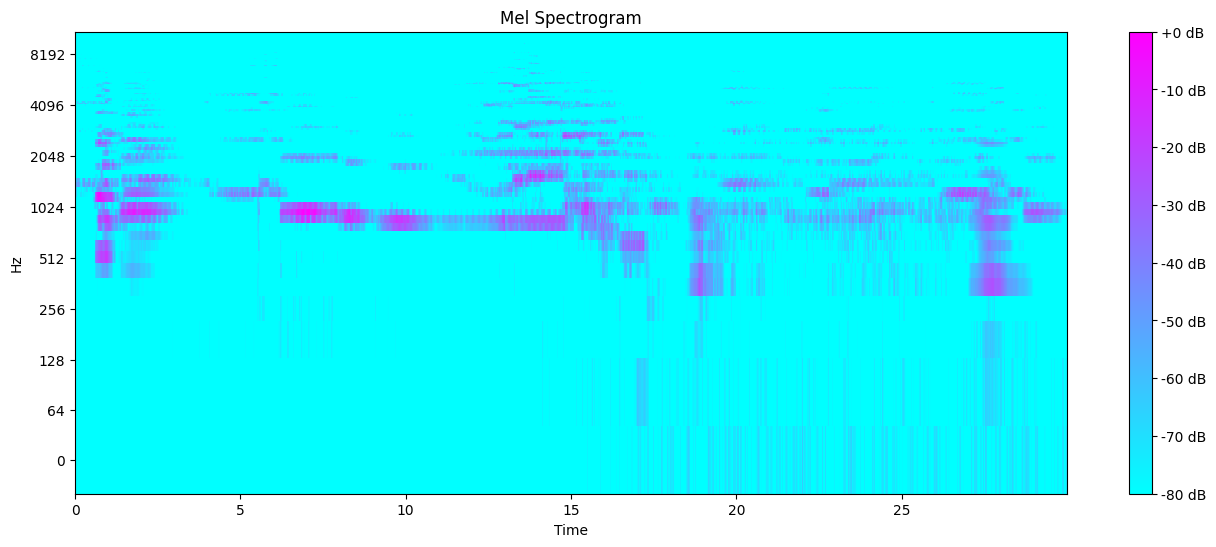

In [7]:
# Visualizar una muestra
import librosa.display
import matplotlib.pyplot as plt
import numpy as np


y, sr = librosa.load('/content/drive/MyDrive/7ptimo Sem/bigData Proyect/music_data//genres_original/classical/classical.00036.wav', duration=30)
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)

plt.figure(figsize=(16, 6))
librosa.display.specshow(S_DB, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()


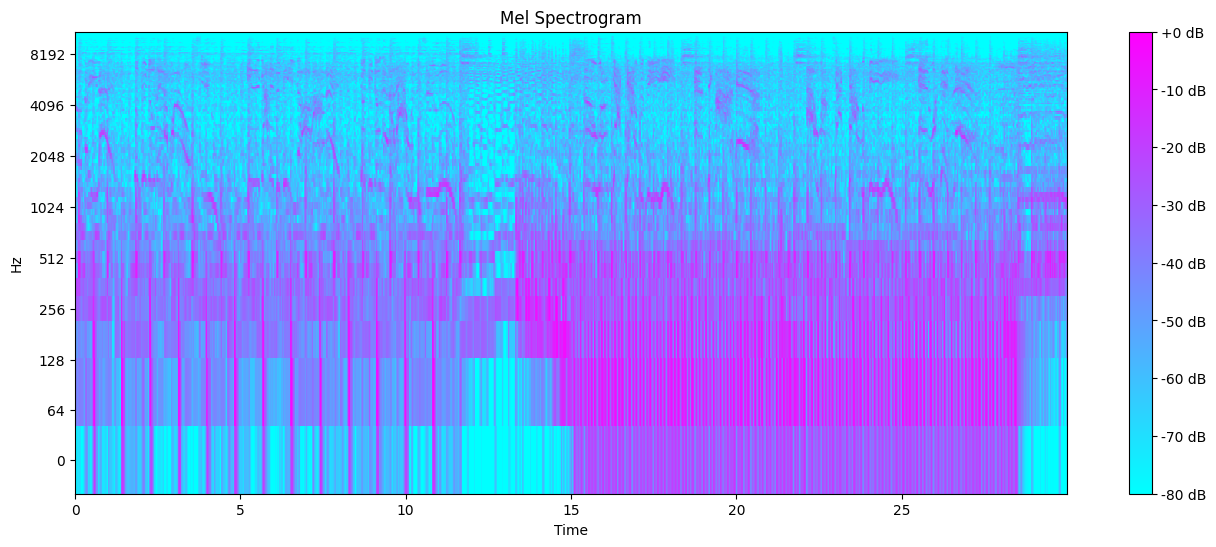

In [8]:
# Visualizar segunda muestra

y, sr = librosa.load('/content/drive/MyDrive/7ptimo Sem/bigData Proyect/music_data/genres_original/metal/metal.00036.wav', duration=30)
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)

plt.figure(figsize=(16, 6))
librosa.display.specshow(S_DB, x_axis='time', y_axis='log', cmap='cool')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.show()

Cargamos el archivo '.csv' correspondiente a las diferentes características de las canciones

In [9]:
# Cargar el archivo CSV en PySpark
data_df = spark.read.csv('/content/drive/MyDrive/7ptimo Sem/bigData Proyect/music_data/features_3_sec.csv', header=True, inferSchema=True)
data_df.show(5)


+-----------------+------+-------------------+-------------------+-------------------+--------------------+----------------------+---------------------+-----------------------+----------------------+------------------+------------------+-----------------------+----------------------+--------------------+--------------------+--------------------+--------------------+------------+-------------------+-----------------+------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----------------+-------------------+------------------+------------------+------------------+-------------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+------------------+-------------------+------------------+-------------------+-----------------+---------

Se preparan las caracteríosticas del dataset para el entrenamiento del modelo.

Se vectorizan todas las columnas numéricas en una sola columna de características llamadas features.

Se utiliza la normalización para escalar las características en el rango [0, 1] generando la columna 'scaled_features'. Esto ayuda a mejorar el rendimiento y la estabilidad del modelo.


In [10]:
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

# Excluir la columna 'filename' ya que es de tipo string
assembler = VectorAssembler(inputCols=[col for col in data_df.columns if col not in ['filename', 'label']], outputCol='features')
assembled_df = assembler.transform(data_df)

# Normalizar las características
scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df)



Usamos una indexación para convertir la columna 'label' que contiene géneros como cadenas de texto, en valores numéricos para poder trabjar con los datos.

Se divide el conjunto de datos en 80% para entrenamiento y 20% para prueba para evaluar la precisión del modelo.

Creamos el modelo RandomForestClassifier con 100 arboles de decisión y entrenamos con el conjunto de datos de entrenamiento.

Usamos el modelo entrenado para hacer predicciones en el conjunto de prueba y evaluamos la precisión del modelo.

In [11]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer

# Convertir la columna 'label' en valores numéricos
indexer = StringIndexer(inputCol="label", outputCol="label_indexed")
data_df = indexer.fit(scaled_df).transform(scaled_df)

# Usar la columna 'label_indexed' en lugar de 'label'
train_data, test_data = data_df.randomSplit([0.8, 0.2])

# Crear el modelo de Random Forest
rf = RandomForestClassifier(labelCol="label_indexed", featuresCol="scaled_features", numTrees=100)
model = rf.fit(train_data)

# Hacer predicciones
predictions = model.transform(test_data)

# Evaluar el modelo
evaluator = MulticlassClassificationEvaluator(labelCol="label_indexed", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Precisión del modelo: {accuracy}")



Precisión del modelo: 0.5738035264483627


Calculamos varias métricas clave de rendimiento para evaluar el modelo:

F1 Score: Mide el equilibrio entre precisión y exhaustividad.

Precisión: Representa la proporción de predicciones correctas del modelo para cada clase, ponderada por la cantidad de instancias.

Recall: Calcula la capacidad del modelo para detectar todas las intancias relevantes de cada clase.


In [12]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label_indexed", predictionCol="prediction", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)

evaluator_precision = MulticlassClassificationEvaluator(labelCol="label_indexed", predictionCol="prediction", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(predictions)

evaluator_recall = MulticlassClassificationEvaluator(labelCol="label_indexed", predictionCol="prediction", metricName="weightedRecall")
recall = evaluator_recall.evaluate(predictions)

print(f"F1 Score: {f1_score}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


F1 Score: 0.5416258141230961
Precision: 0.5643946945125331
Recall: 0.5738035264483627


Guardamos el resultado de cada métrica en un '.csv' para poder realizar ciertos análisis y visualizaciones al respecto.

In [13]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Assuming `predictions` is your dataframe with columns "label_indexed" (actual) and "prediction" (predicted)
y_true = predictions.select("label_indexed").toPandas()
y_pred = predictions.select("prediction").toPandas()

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# Organize into a DataFrame for export
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Value': [accuracy, precision, recall, f1]
})

# Save to CSV
metrics_df.to_csv('/content/model_metrics.csv', index=False)
print("Metrics saved to model_metrics.csv")


Metrics saved to model_metrics.csv


In [18]:
from sklearn.metrics import confusion_matrix
import pandas as pd

y_true = predictions.select("label_indexed").toPandas()
y_pred = predictions.select("prediction").toPandas()
conf_matrix = confusion_matrix(y_true, y_pred)

# Convertir a DataFrame para exportar
conf_matrix_df = pd.DataFrame(conf_matrix)
conf_matrix_df.to_csv("confusion_matrix.csv", index=False)


In [14]:
scaled_df.show()

+-----------------+------+-------------------+-------------------+-------------------+--------------------+----------------------+---------------------+-----------------------+----------------------+------------------+------------------+-----------------------+----------------------+--------------------+--------------------+--------------------+--------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+------------------+--------------------+--------------

Esta sección permite encontrar canciones similares basándose en las características extraídas y normalizadas de cada archivo de audio.

Se selecciona una canción de referencia y se extraen sus características

Con 'cosine_similarity' de sklearn, se calcula la similitud entre la canción de referencia y todas las demás canciones.

Se ordenan los resultados de mayor a menor similitud.

In [15]:
from pyspark.sql.functions import col
from sklearn.metrics.pairwise import cosine_similarity

# Seleccionar la canción de referencia
cancion_ref_row = scaled_df.filter(col("filename") == "pop.00001.9.wav").select("scaled_features").first()

if cancion_ref_row is not None:
    cancion_ref = cancion_ref_row["scaled_features"]

    # Calcular la similaridad de coseno
    scaled_features = scaled_df.select("filename", "scaled_features").collect()
    similarities = []

    for row in scaled_features:
        sim = cosine_similarity([cancion_ref], [row["scaled_features"]])[0][0]
        similarities.append((row["filename"], sim))

    # Ordenar por similaridad
    sorted_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)

    # Mostrar las canciones más similares
    print(f"Similar songs to {'pop.00001.9.wav'}:")
    for song, sim in sorted_similarities[:5]:
        print(f"{song}: {sim}")
else:
    print("No se encontró la canción de referencia.")


Similar songs to pop.00001.9.wav:
pop.00001.9.wav: 1.0000000000000002
pop.00001.7.wav: 0.9894294669497677
pop.00001.8.wav: 0.9891895391417428
pop.00054.8.wav: 0.9875013617040863
pop.00060.8.wav: 0.9875013617040863


In [17]:
# Buscar canciones similares a "jazz.00023.wav"
cancion_ref_row = scaled_df.filter(col("filename") == "jazz.00002.3.wav").select("scaled_features").first()

if cancion_ref_row is not None:
    cancion_ref = cancion_ref_row["scaled_features"]
    similarities = []
    for row in scaled_df.select("filename", "scaled_features").collect():
        sim = cosine_similarity([cancion_ref], [row["scaled_features"]])[0][0]
        similarities.append((row["filename"], sim))
    sorted_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    print("Similar songs to jazz.00023.wav:")
    for song, sim in sorted_similarities[:5]:
        print(f"{song}: {sim}")

# Buscar canciones similares a "classical.00012.wav"
cancion_ref_row = scaled_df.filter(col("filename") == "classical.00001.2.wav").select("scaled_features").first()

if cancion_ref_row is not None:
    cancion_ref = cancion_ref_row["scaled_features"]
    similarities = []
    for row in scaled_df.select("filename", "scaled_features").collect():
        sim = cosine_similarity([cancion_ref], [row["scaled_features"]])[0][0]
        similarities.append((row["filename"], sim))
    sorted_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    print("Similar songs to classical.00012.wav:")
    for song, sim in sorted_similarities[:5]:
        print(f"{song}: {sim}")

# Buscar canciones similares a "rock.00045.wav"
cancion_ref_row = scaled_df.filter(col("filename") == "rock.00004.5.wav").select("scaled_features").first()

if cancion_ref_row is not None:
    cancion_ref = cancion_ref_row["scaled_features"]
    similarities = []
    for row in scaled_df.select("filename", "scaled_features").collect():
        sim = cosine_similarity([cancion_ref], [row["scaled_features"]])[0][0]
        similarities.append((row["filename"], sim))
    sorted_similarities = sorted(similarities, key=lambda x: x[1], reverse=True)
    print("Similar songs to rock.00045.wav:")
    for song, sim in sorted_similarities[:5]:
        print(f"{song}: {sim}")

Similar songs to jazz.00023.wav:
jazz.00002.3.wav: 1.0
blues.00015.2.wav: 0.9523086716473746
country.00067.2.wav: 0.9466689341844969
jazz.00002.4.wav: 0.9454723078807171
blues.00007.7.wav: 0.9454326164847413
Similar songs to classical.00012.wav:
classical.00001.2.wav: 1.0
jazz.00020.1.wav: 0.9866743762194929
classical.00005.2.wav: 0.9847780903575873
classical.00041.8.wav: 0.983937931673703
classical.00013.2.wav: 0.9834167522626617
Similar songs to rock.00045.wav:
rock.00004.5.wav: 0.9999999999999998
rock.00004.3.wav: 0.9929950507373548
rock.00004.4.wav: 0.9923634618954019
rock.00004.9.wav: 0.9916557868657883
rock.00072.3.wav: 0.9891049925251226


Acceso a presentación con las visualizaciones:

https://docs.google.com/presentation/d/1jXcinFKZj0Xoq_CcvO-0RrMlgjQwATB6/edit?usp=sharing&ouid=109425574979846414898&rtpof=true&sd=true


![image.png]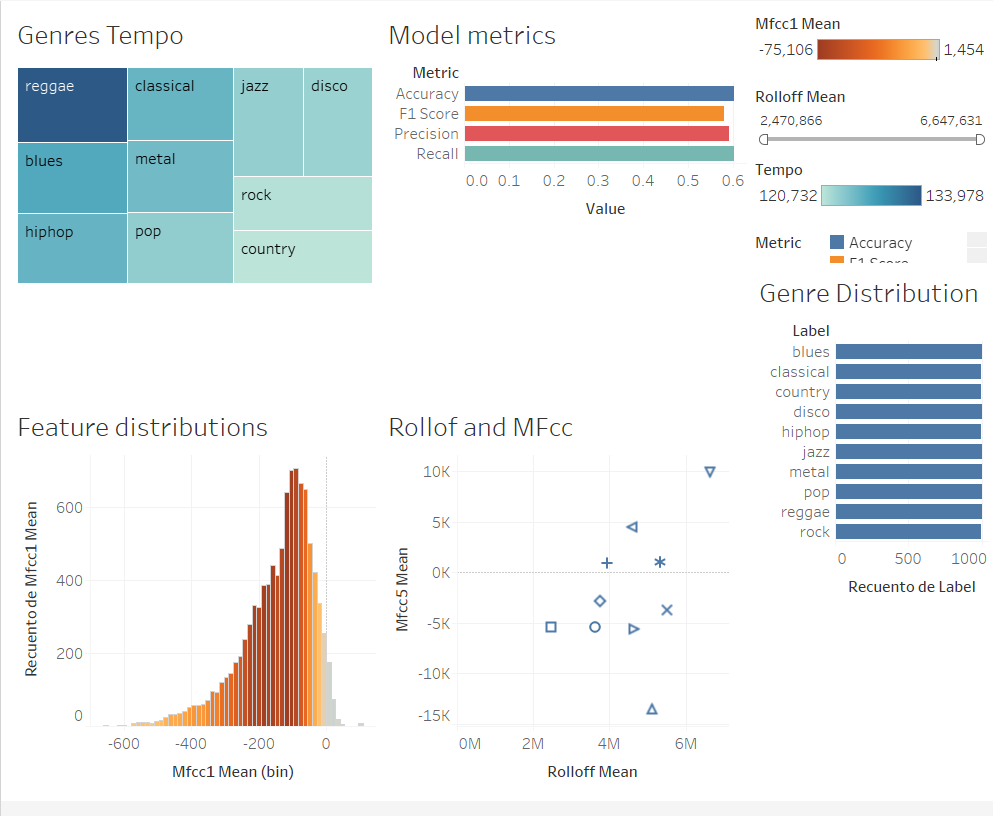